# Tarea Dask

## Instrucciones generales
- Esta tarea debe realizarse de manera individual
- Este notebook (resuelto) debe ser subido al github del proyecto en la carpeta de tareas (creen una carpeta dentro de esa carpeta y agreguen su notebook reuelto)
- Fecha límite: Lunes 25 de noviembre de 2024 a las 11:59 p.m
- Deben realizar las cuatro secciones
- Puedes agregar tantas celdas de código y explicaciones como veas necesario, solo manten la estructura general

## Sección 0 Creación y Configuración del cliente de Dask
Ejercicio 0: Configuración del cliente
1. Crea un cliente local de Dask que inicie un clúster en tu máquina.
2. Configura el cliente para que tenga las siguientes características (elige un par de las opciones de trabajadores e hilos):
    - Número de trabajadores: 2 / 4
    - Memoria máxima por trabajador: 1GB
    - Threads por trabajador: 4 / 2
3. Verifica que el cliente esté funcionando correctamente mostrando:
    - Resumen de los trabajadores activos.
    - Dashboard disponible (URL del panel de control de Dask).
    * Tip: Checa los parámetros del cliente que creeaste.

*Nota*: Puedes hacer que corra en el puerto que desees.

In [4]:
# Tu código va aquí
from dask.distributed import Client, LocalCluster

# Configuración del clúster local
cluster = LocalCluster(
    n_workers=2,              # Número de trabajadores
    threads_per_worker=4,     # Hilos por trabajador
    memory_limit="1GB"        # Memoria máxima por trabajador
)

# Crear cliente conectado al clúster
client = Client(cluster)

# Mostrar información del cliente y verificar su funcionamiento
print("Resumen de los trabajadores activos:")
print(client)  # Resumen detallado del cliente

print("\nURL del panel de control de Dask (Dashboard):")
print(client.dashboard_link)  # Enlace al dashboard de Dask

# Información adicional sobre los trabajadores
workers_info = client.scheduler_info()['workers']
print("\nInformación detallada de los trabajadores:")
for worker, info in workers_info.items():
    print(f"Trabajador: {worker}")
    print(f"  Estado: {info.get('status', 'N/A')}")
    print(f"  Hilos: {info.get('nthreads', 'N/A')}")
    print(f"  Memoria usada (aproximada): {info.get('metrics', {}).get('memory', 'No disponible')} bytes")
    print(f"  Memoria límite: {info.get('memory_limit', 'N/A')} bytes")




/usr/local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32835 instead
  warnings.warn(


Resumen de los trabajadores activos:
<Client: 'tcp://127.0.0.1:35535' processes=2 threads=8, memory=1.86 GiB>

URL del panel de control de Dask (Dashboard):
http://127.0.0.1:32835/status

Información detallada de los trabajadores:
Trabajador: tcp://127.0.0.1:37499
  Estado: running
  Hilos: 4
  Memoria usada (aproximada): 57507840 bytes
  Memoria límite: 1000000000 bytes
Trabajador: tcp://127.0.0.1:45771
  Estado: running
  Hilos: 4
  Memoria usada (aproximada): 57524224 bytes
  Memoria límite: 1000000000 bytes


## Sección 1 Delayed
Ejercicio 1: Procesamiento de datos 

1. Genera datos simulados (por ejemplo, ventas diarias) para 10 sucursales durante 365 días.
    - Cada sucursal debe tener datos generados aleatoriamente para "Ingresos" y "Costos".
    - Utiliza una función para generar los datos simulados.
2. Usa Dask Delayed para calcular:
    - Las ganancias diarias por sucursal.
    - La sucursal con mayor ganancia promedio.
3. Genera un grafo de tareas que visualice estas operaciones y explica por qué elegiste paralelizar de esa forma, genera una visualización del grafo.

In [2]:
# Tu código va aquí
import numpy as np
import dask
from dask import delayed

# Paso 1: Generar datos simulados
def generate_branch_data(branch_id, days=365):
    np.random.seed(branch_id)  # Semilla para reproducibilidad
    ingresos = np.random.randint(1000, 5000, days)  # Ingresos diarios
    costos = np.random.randint(500, 3000, days)  # Costos diarios
    return ingresos, costos

# Paso 2: Función para calcular ganancias diarias
@delayed
def calculate_daily_gains(ingresos, costos):
    return ingresos - costos

# Paso 3: Función para calcular ganancia promedio de una sucursal
@delayed
def average_gain(daily_gains):
    return daily_gains.mean()

# Crear datos para 10 sucursales
branches = []
for branch_id in range(10):
    ingresos, costos = generate_branch_data(branch_id)
    daily_gains = calculate_daily_gains(ingresos, costos)
    branches.append((branch_id, daily_gains))

# Paso 4: Calcular las ganancias promedio por sucursal
average_gains = [(branch_id, average_gain(daily_gains)) for branch_id, daily_gains in branches]

# Paso 5: Determinar la sucursal con la mayor ganancia promedio
@delayed
def find_best_branch(avg_gains):
    return max(avg_gains, key=lambda x: x[1])  # Seleccionar la sucursal con mayor ganancia promedio

best_branch = find_best_branch(average_gains)



# Computar resultados finales
result = best_branch.compute()
print(f"Sucursal con mayor ganancia promedio: {result[0]} con ganancia promedio de {result[1]:.2f}")


Sucursal con mayor ganancia promedio: 2 con ganancia promedio de 1379.75


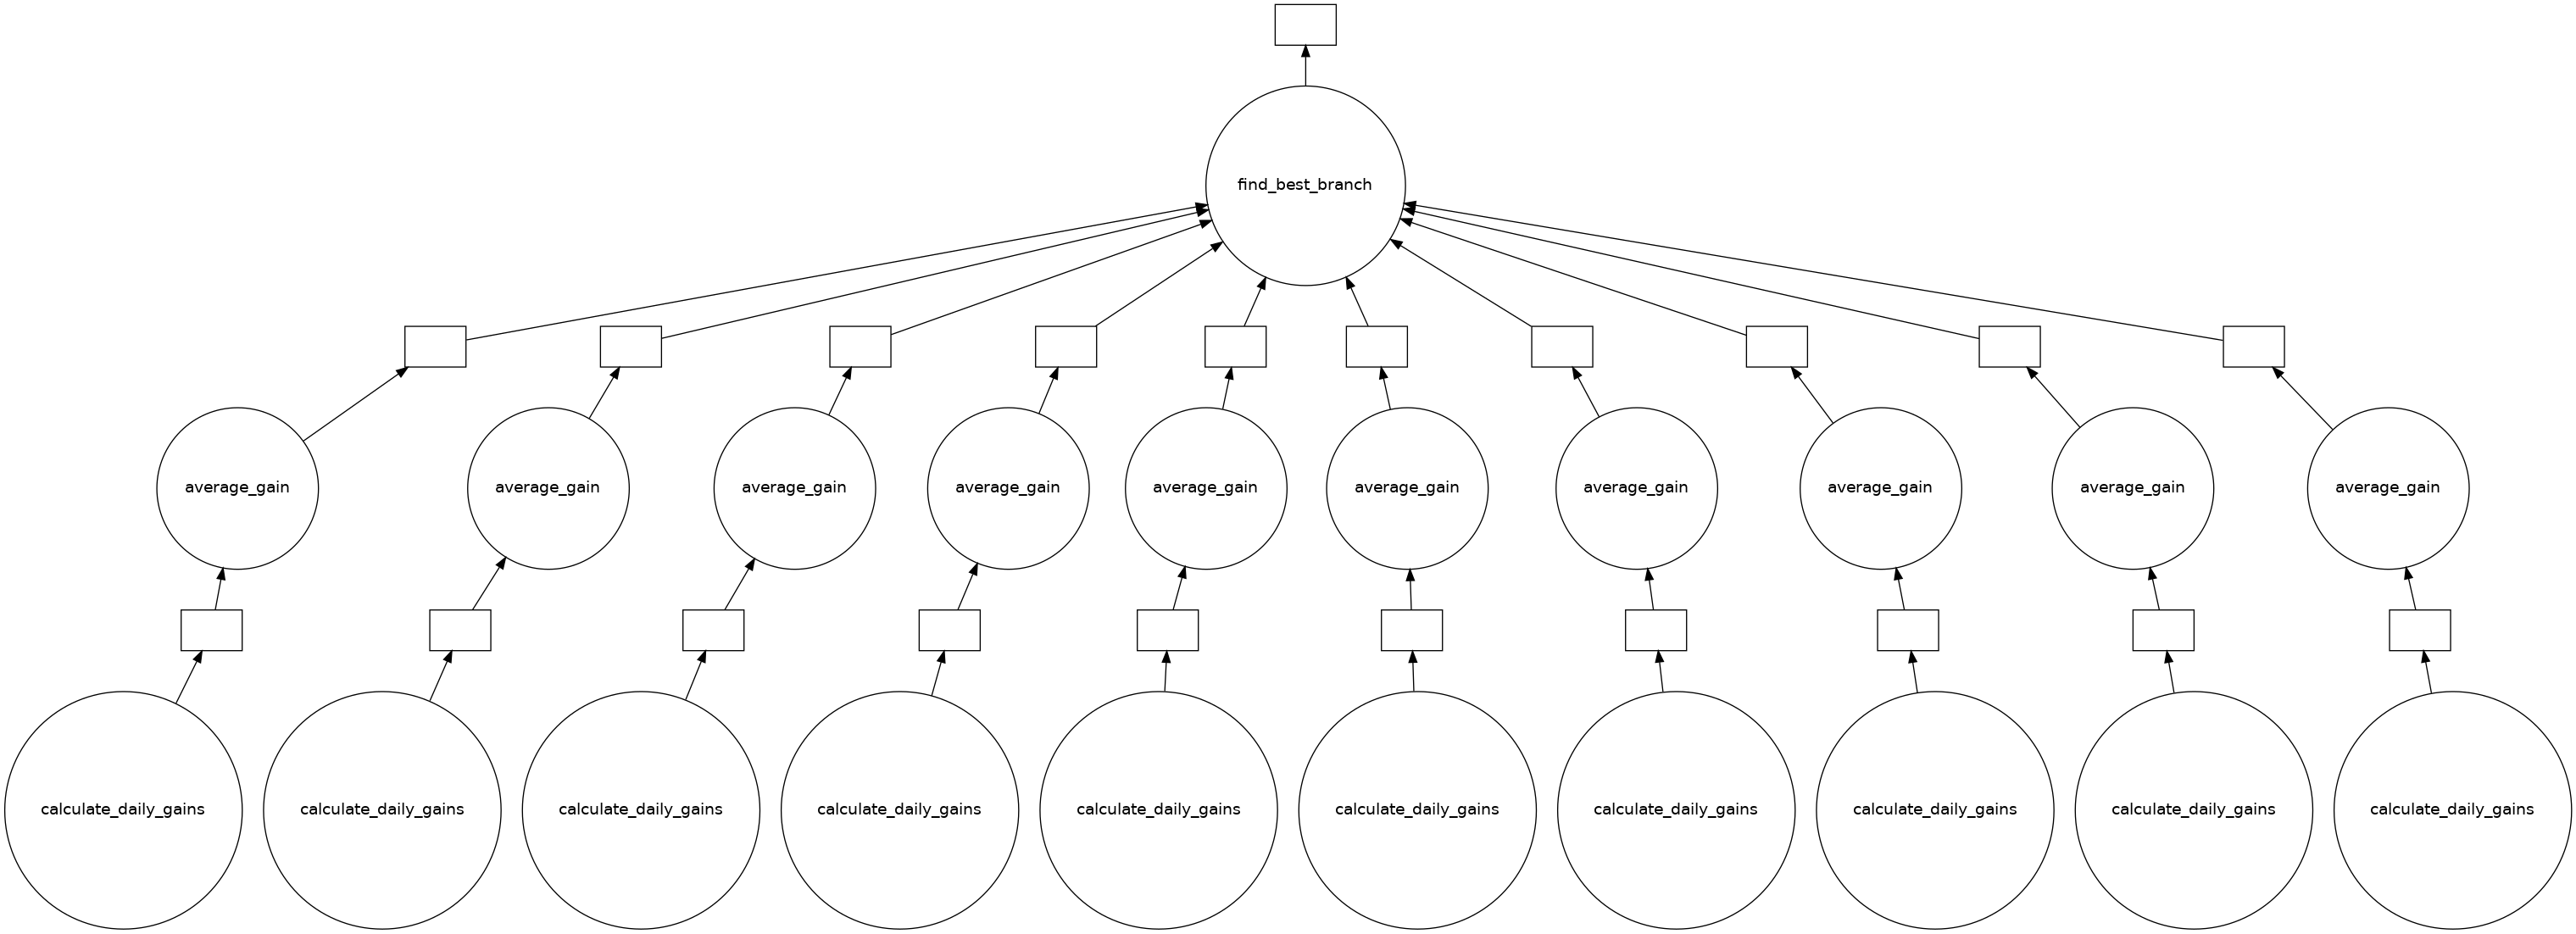

In [3]:
# Visualizar el grafo de tareas
dask.visualize(best_branch, filename='task_graph', format='png')

In [ ]:
Decidí paralelizar por sucursal porque cada cálculo de ganancias
diarias y promedios es independiente y no requiere comunicación entre 
sucursales. Esto permite a Dask dividir el trabajo de manera eficiente, 
distribuyendo las


## Sección 2 Dask Dataframes
Ejercicio 2: Limpieza y análisis de datos reales

1. Descarga un conjunto de datos masivo (puedes usar la colección de *nycflights* que se encuentra en `data/nycflights/`).
2. Carga los datos en un Dask DataFrame. 
    - Elige adecuadamente el número de particiones (que quepan en memoria de los `workers`)
3. Realiza las siguientes tareas:
    - Limpia los valores faltantes en las columnas `ArrDelay` y `DepDelay`, rellenándolos con la mediana de cada columna.
    - Calcula el retraso promedio (`DepDelay`) por mes y aerolínea.
    - Encuentra el aeropuerto de origen con más vuelos retrasados.

*Nota*: **Evita** convertir el DataFrame a pandas e **intenta** realizar `.compute()` solo cuando sea necesario.

In [9]:
# Tu código va aquí
import dask.dataframe as dd


file_path = 'data/nycflights/*.csv'

# Especificar tipos de datos manualmente
dtypes = {
    'CRSElapsedTime': 'float64',  # Se asegura que sea float64
    'TailNum': 'object',         # Se asegura que sea tipo texto
    # Agregar más columnas si es necesario con sus tipos correctos
}

# Cargar los archivos CSV con los tipos de datos especificados
df = dd.read_csv(file_path, dtype=dtypes)

# Mostrar las primeras filas para verificar
print("Estructura del DataFrame:")
print(df.head())

# Ajustar particiones para que cada una sea manejable por los workers
df = df.repartition(npartitions=4)  # Ajusta el número según tu memoria disponible
print(f"Número de particiones ajustado: {df.npartitions}")

# Paso 2: Limpieza de valores faltantes
# Calcular la mediana aproximada de ArrDelay y DepDelay
arr_delay_median = df['ArrDelay'].quantile(0.5).compute()
dep_delay_median = df['DepDelay'].quantile(0.5).compute()

# Rellenar valores faltantes con la mediana aproximada
df['ArrDelay'] = df['ArrDelay'].fillna(arr_delay_median)
df['DepDelay'] = df['DepDelay'].fillna(dep_delay_median)

# Verificar que no haya valores nulos restantes
print("\nValores nulos después de la limpieza:")
print(df.isnull().sum().compute())

# Paso 3: Análisis
# Retraso promedio (DepDelay) por mes y aerolínea
monthly_delay = df.groupby(['Month', 'UniqueCarrier'])['DepDelay'].mean().compute()
print("\nRetraso promedio por mes y aerolínea:")
print(monthly_delay)

# Aeropuerto de origen con más vuelos retrasados
# Definir vuelo retrasado como DepDelay > 15 minutos
delayed_flights = df[df['DepDelay'] > 15]
most_delayed_origin = delayed_flights.groupby('Origin')['DepDelay'].count().idxmax().compute()
print(f"\nAeropuerto de origen con más vuelos retrasados: {most_delayed_origin}")

Estructura del DataFrame:
   Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  1990      1           1          1   1621.0        1540   1747.0   
1  1990      1           2          2   1547.0        1540   1700.0   
2  1990      1           3          3   1546.0        1540   1710.0   
3  1990      1           4          4   1542.0        1540   1710.0   
4  1990      1           5          5   1549.0        1540   1706.0   

   CRSArrTime UniqueCarrier  FlightNum  ... AirTime  ArrDelay  DepDelay  \
0        1701            US         33  ...     NaN      46.0      41.0   
1        1701            US         33  ...     NaN      -1.0       7.0   
2        1701            US         33  ...     NaN       9.0       6.0   
3        1701            US         33  ...     NaN       9.0       2.0   
4        1701            US         33  ...     NaN       5.0       9.0   

   Origin  Dest  Distance TaxiIn TaxiOut  Cancelled  Diverted  
0     EWR   PIT     319.0    NaN

2024-11-21 00:28:04,961 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 763.04 MiB -- Worker memory limit: 0.93 GiB
2024-11-21 00:28:04,997 - distributed.worker.memory - WARNING - Worker is at 50% memory usage. Resuming worker. Process memory: 482.25 MiB -- Worker memory limit: 0.93 GiB
2024-11-21 00:28:05,250 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 772.85 MiB -- Worker memory limit: 0.93 GiB
2024-11-21 00:28:05,298 - distributed.worker.memory - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 552.14 MiB -- Worker memory limit: 0.93 GiB


Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                70931
CRSDepTime                 0
ArrTime                78210
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum              1313006
ActualElapsedTime      78210
CRSElapsedTime          1965
AirTime              1356823
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                1495
TaxiIn               1313006
TaxiOut              1313006
Cancelled                  0
Diverted                   0
dtype: int64

Retraso promedio por mes y aerolínea:
Month  UniqueCarrier
1      AA                8.963504
       CO               11.693346
       DL                9.249338
       EA               24.258191
       HP               18.697144
                          ...    
12     NW                9.705670
       PA (1)         

## Sección 3 Dask Arrays

Ejercicio 3: Procesamiento numérico avanzado

1. Crea un arreglo de 10,000 x 10,000 con valores aleatorios usando Dask Array, utiliza un tamaño de chunks adecuado, ¿es mejor que sean cuadrados?.
2. Realiza las siguientes operaciones:
    - Calcula la suma de cada fila.
    - Encuentra la fila con el valor máximo promedio.
    - Multiplica todo el arreglo por un factor escalar (por ejemplo, 2.5).
3. Divide el arreglo nuevamente en 100 bloques y compara la rapidez.

In [11]:
# Tu código va aquí
import dask.array as da
import time

# Paso 1: Crear un arreglo 10,000 x 10,000 con valores aleatorios
shape = (10000, 10000)
#escogi chunks de 1000, porque dijero que lo optimo era entre 10. 
#es una elección adecuada ya que balancea la carga de trabajo y se ajusta bien a la memoria disponible
#Si conviene usar chunks cuadrados, 
#Chunks cuadrados distribuyen las operaciones de manera uniforme entre los trabajadores.
#Esto ayuda a evitar que algunos chunks sean más pesados de procesar que otros.
#Para operaciones como multiplicaciones, sumas o transformaciones de matrices, 
#los chunks cuadrados son ideales porque minimizan las dependencias entre bloques.
chunk_size = (1000, 1000)  # Chunks cuadrados de 1000 x 1000
array = da.random.random(shape, chunks=chunk_size)

print("Arreglo creado:")
print(array)

# Paso 2: Calcular la suma de cada fila
row_sums = array.sum(axis=1)

# Computar la suma de las filas y mostrar la forma del resultado
row_sums_computed = row_sums.compute()
print("\nSuma de cada fila (primeros 10 valores):")
print(row_sums_computed[:10])

# Paso 3: Encontrar la fila con el valor máximo promedio
row_means = array.mean(axis=1)
max_row_index = row_means.argmax().compute()
print(f"\nÍndice de la fila con el valor máximo promedio: {max_row_index}")

# Paso 4: Multiplicar todo el arreglo por un factor escalar
scalar = 2.5
scaled_array = array * scalar

# Paso 5: Dividir el arreglo en 100 bloques y comparar rapidez
# Reconfigurar chunks en 100 bloques
new_chunk_size = (array.shape[0] // 10, array.shape[1] // 10)  # Divide en bloques de 100 x 100
start_time = time.time()
rechunked_array = scaled_array.rechunk(new_chunk_size)
print(f"\nReconfiguración de chunks completada en {time.time() - start_time:.2f} segundos.")

# Mostrar el arreglo reconfigurado
print("\nArreglo reconfigurado:")
print(rechunked_array)


Arreglo creado:
dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Suma de cada fila (primeros 10 valores):
[4971.69528931 4986.50806879 4980.62337409 5002.45047915 5059.80285318
 4991.81024332 4923.59371675 5011.87357736 5014.01459189 4989.76899092]

Índice de la fila con el valor máximo promedio: 5788

Reconfiguración de chunks completada en 0.00 segundos.

Arreglo reconfigurado:
dask.array<mul, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>


## Sección 4 Futures
Ejercicio 4: Distribución de tareas dinámicas

1. Implementa una función que calcule la raíz cuadrada de una lista de 100,000 números enteros generados aleatoriamente.
2. Divide la lista en 10 partes iguales y usa Dask Futures para calcular la raíz cuadrada de cada parte en paralelo.
3. Recolecta los resultados y calcula:
    - El promedio de todos los números procesados.
    - El tiempo total de ejecución (incluyendo envío y recolección de tareas).
4. Observa como se distribuye la carga en el cliente.

*Nota*: en los ejercicios ya vimos como determinar si ya se cumplío una tarea.

In [ ]:
# Tu código va aquí

import numpy as np
from dask.distributed import Client
import time

# Paso 1: Configurar el cliente de Dask
client = Client()  # Esto inicializa un clúster local y habilita el dashboard
print(f"Dashboard de Dask disponible en: {client.dashboard_link}")

# Paso 2: Generar una lista de 100,000 números enteros aleatorios
n_numbers = 100_000
numbers = np.random.randint(1, 1000, size=n_numbers)

# Paso 3: Dividir la lista en 10 partes iguales
n_chunks = 10
chunk_size = n_numbers // n_chunks
chunks = [numbers[i * chunk_size:(i + 1) * chunk_size] for i in range(n_chunks)]

# Paso 4: Definir la función para calcular la raíz cuadrada
def compute_sqrt(data):
    return np.sqrt(data)

# Paso 5: Enviar tareas a Dask con Futures
start_time = time.time()
futures = [client.submit(compute_sqrt, chunk) for chunk in chunks]

# Puedes observar el estado de las tareas en el dashboard mientras se procesan.

# Paso 6: Recolectar resultados
results = client.gather(futures)

# Calcular el tiempo total de ejecución
total_time = time.time() - start_time

# Paso 7: Calcular el promedio de todos los números procesados
all_sqrts = np.concatenate(results)
mean_result = all_sqrts.mean()

# Mostrar resultados
print(f"Promedio de los números procesados: {mean_result:.2f}")
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")
print("Carga distribuida en el cliente: Consulta el dashboard en el URL proporcionado.")

# Mantener el cliente vivo para observar el dashboard (opcional)
input("Presiona Enter para finalizar y cerrar el cliente...")
client.close()


Dashboard de Dask disponible en: http://127.0.0.1:8787/status
Promedio de los números procesados: 21.10
Tiempo total de ejecución: 0.06 segundos
Carga distribuida en el cliente: Consulta el dashboard en el URL proporcionado.
